In [1]:
from qdrant_client import QdrantClient


def add_svm_documents(client):
    with open('svm.txt', 'r', encoding='utf-8') as file:
        documents = file.readlines()
    documents = [doc.strip() for doc in documents]
    client.add(collection_name="knowledge-base", documents=documents)

# def add_decision_tree_documents(client):
#     with open('decision_tree.txt', 'r', encoding='utf-8') as file:
#         documents = file.readlines()
#     documents = [doc.strip() for doc in documents]
#     client.add(collection_name="knowledge-base", documents=documents)

def add_decision_tree_documents(client):
    with open('decision_tree.txt', 'r', encoding='utf-8') as file:
        documents = file.readlines()
    documents = [doc.strip() for doc in documents]
    client.add(collection_name="knowledge-base", documents=documents)

def add_sklearn_tree_documents(client):
    with open('sklearn.tree.txt', 'r', encoding='utf-8') as file:
        documents = file.readlines()
    documents = [doc.strip() for doc in documents]
    client.add(collection_name="knowledge-base", documents=documents)

client = QdrantClient(":memory:")

user_input = input("Enter the model you want to add documents from (decision_tree, sklearn_tree, etc.): ")

if user_input.lower() == 'decision_tree':
    add_decision_tree_documents(client)
elif user_input.lower() == 'sklearn_tree':
    add_sklearn_tree_documents(client)
else:
    add_svm_documents(client)

In [2]:
import json
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
def to_numeric(F6):
    if F6 == "?":
        return np.nan
    else:
        return int(F6)

def file_preprocess(filename):
    df = pd.read_csv(filename)
    df['F6'] = df['F6'].apply(to_numeric)
    mean_F6 = df['F6'].mean()
    df['F6'] = df['F6'].fillna(mean_F6)
    return df

def runner(json_file, model_file):
    # Load parameters from JSON
    with open(json_file, 'r') as file:
        parameters = json.load(file)
    with open(model_file, 'r') as file:
        model_param = json.load(file)

    model_name = parameters['model_name']
    df = file_preprocess(parameters['filename'])

    #Check for target_variable is present or not
    target_variable = parameters.get("target_variable", None)
    if target_variable is None:
        raise ValueError("Target variable not specified in the parameters.")

    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    # Define default parameters for SVMClassifier

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=parameters['split'], random_state=42)

    def_param = {
      "decision_tree" : {"param_dict" : "default_decision_tree_parameters", "lib_name" : "DecisionTreeClassifier"},
      "svm" : {"param_dict" : "default_svm_parameters", "lib_name" : "SVC"},
      "lr" : {"param_dict" : "default_lr_parameters", "lib_name" : "LogisticRegression"}
    }

    params = def_param[model_name]["param_dict"]
#     print(params)
    param = model_param[params]
    lib_name = def_param[model_name]["lib_name"]
#     print(param)

    # Merge default and user-provided parameters
    merged_parameters = {**param, **parameters.get("param", {})}
    # print(merged_parameters)
    
    # Initialize the Decision Tree model with the merged parameters
    model = eval(lib_name)(**merged_parameters)

    # Train the Decision Tree model
    model.fit(X_train, y_train)
    para= model.get_params()
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    #accuracy = accuracy_score(y_test, y_pred)
    
    acc = accuracy_score(y_test, y_pred)
#     print(f"Accuracy: {acc}")
    cr = classification_report(y_test,y_pred)
#     print(cr)
    cf_matrix = confusion_matrix(y_test, y_pred)
#     print(cf_matrix)
    
    mmy_dict = {"accuracy" : acc, "class_report" : cr, "conf_mat" : cf_matrix,"paramters" : para}
    print(acc)
    return mmy_dict
    print(merged_parameters)
    
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = ai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response
def make_json(chat_history1):
    prompt = f"""
    read the chat history between the user and the chatbot and create a dictionary of the model parameters finalized by them. include filename and append the dataset filename with .csv extension. create  a dictionary named param (which would be the parameters of the model) and write all the parameters asked by the user in the datatype of what the function requires. 
    include 'target_variable' as mentioned in the prompt. and 'split' should be 0.2 unless some other value is specified. an example for svm model might look like this (with curly brackets instead of sqauare brackets) also make sure you write the model name compatible to the sklearn libraries:
    [
    
    "filename" : "breast-cancer-wisconsin.csv",
    "model_name" : "decision_tree",
    "param": [
        "kernel": "linear"
    ],
    "target_variable": "Class",
    "split" : 0.2
    ]
    text = ```{chat_history1}```
    """
    json_objects = get_completion(prompt)
    json_object = json_objects.choices[0].message.content

    print(json_objects)
    data_dict = json.loads(json_object)
    json_file_path = "sample.json"
    with open(json_file_path, 'w') as json_file:
        json.dump(data_dict, json_file,indent=2)
    result = runner("sample.json", "model_parameters.json")
    return result


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
import os
os.environ["OPENAI_API_KEY"] = "###"
from openai import OpenAI
ai = OpenAI()
def rag(chat_history: list[str], question: str, n_points: int = 3) -> str:
    results = client.query(
        collection_name="knowledge-base",
        query_text=question,
        limit=n_points,
    )
    
    context = "\n".join(r.document for r in results)
    metaprompt = f"""
    You are a helpful machine learning bot.
    Answer the following question using the provided context.
    If the user asks you to build a model, return -1 as response. Always make sure you are checking this first before giving any response
    Also refer to the chat history while answering a question. consider info given by the assisstant only as truth.
    The context provided is only documentation for referring information. When asked direct questions about model building remember answers in the chat history and when asked factual question about the docs explicitly, refer to the context documentation. 
    If you can't find the answer, do not pretend you know it, but answer "I don't know".
    If you have limited information on something, state is and then answer "this is all I know." irrespective of how much their word count expectation is.
    
    Question: {question}
    CHAT HISTORY : {chat_history}
   Context:
    {context.strip()}

    Answer:
    """

    results = ai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful machine learning bot."},
            {"role": "user", "content": metaprompt},
        ],
    )

    return results

Welcome to the Transformers chatbot! Type done when you want run the model. Type 'exit' to stop.


/var/folders/09/kkd4kch12b35yvx1xk3m4gr00000gn/T/ipykernel_8579/1434911890.py:42: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HTML(value='<b>User:</b> what is kernel')

HTML(value='<b><font color="blue">Chatbot:</font></b> A kernel in machine learning refers to a function that c…

ChatCompletion(id='chatcmpl-8QKmxKbqpgbWbJzNCF0CZFfszXBCn', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='{\n    "filename": "breast-cancer-wisconsin.csv",\n    "model_name": "svm",\n    "param": {\n        "kernel": "poly"\n    },\n    "target_variable": "Class",\n    "split": 0.2\n}', role='assistant', function_call=None, tool_calls=None))], created=1701287131, model='gpt-3.5-turbo-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=55, prompt_tokens=366, total_tokens=421))
0.6785714285714286
              precision    recall  f1-score   support

           2       0.68      1.00      0.81        95
           4       0.00      0.00      0.00        45

    accuracy                           0.68       140
   macro avg       0.34      0.50      0.40       140
weighted avg       0.46      0.68      0.55       140



/Users/gunik/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gunik/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gunik/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HTML(value='<b>User:</b> build a svm model with for breast-cancer-wisconsin dataset where kernel = poly')

HTML(value='<b><font color="blue">Chatbot:</font></b> The resulting accuracy is 0.6785714285714286')

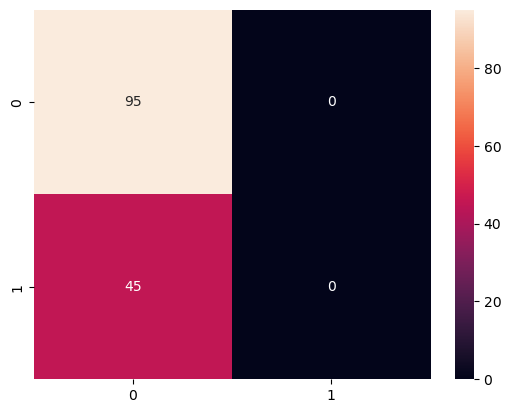

In [ ]:
from IPython.display import display
import ipywidgets as widgets
chat_history = []

def on_submit(_):
    query = input_box.value
    

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return
    # if query.lower() == 'done':

    #     human_tex = chat_history
    #     eval_metrics= make_json(human_tex)
    #     chat_history.append(('what is the accuracy?', f'The resulting accuracy is {eval_metrics}'))
    #     # chat_history.append(('what is the resulting accuracy?', 'the resulting accuracy is '+str(eval_metrics)))
    #     return
    
    response = rag(chat_history, query)
    result = response.choices[0].message.content
    if result == '-1':
        chat_history.append((query, 'building model'))
        # chat_history.append(('what is the resulting accuracy?', 'the resulting accuracy is '+str(eval_metrics)))
        human_tex = chat_history
        eval_metrics= make_json(human_tex)
        # chat_history.append(('what is the accuracy?', f'The resulting accuracy is {eval_metrics}'))
        result = 'The resulting accuracy is ' + str(eval_metrics)
       # print(eval_metrics['class_report'])
       # sns.heatmap(eval_metrics['conf_mat'], annot=True)
        # chat_history.append(('what is the resulting accuracy?', 'the resulting accuracy is '+str(eval_metrics)))

    chat_history.append((query, result))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result}'))
    input_box.value = ""

print("Welcome to the Transformers chatbot! Type done when you want run the model. Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

In [ ]:
chat_history

[('what is linear?',
  'Linear refers to a type of kernel used in the LinearSVC algorithm. When the kernel parameter is set to "linear", LinearSVC assigns weights to the features based on their importance.'),
 ('build me a model on breast-cancer-wisconsin dataset with kernel = linear',
  'building model')]